# Implementation
Author: Jørgen S. Dokken

In this tutorial, you will learn how to:
- Use a vector function space
- Create a constant boundary condition on a vector space
- Visualize cell wise constant functions
- Compute Von Mises stresses

## Test problem
As a test example, we will model a clamped beam deformed under its own weigth in 3D. This can be modeled, by setting the right-hand side body force per unit volume to $f=(0,0,-\rho g)$ with $\rho$ the density of the beam and $g$ the acceleration of gravity. The beam is box-shaped with length $L$ and has a square cross section of width $W$. we set $u=u_D=(0,0,0)$ at the clamped end, x=0. The rest of the boundary is traction free, that is, we set $T=0$. We start by defining the physical variables used in the program.

In [1]:
# Scaled variable  ########################
Length = 1
W = 0.2
nu = 0.23
E =150
rho = 1
#mu = E / (2.0 * (1.0 + nu))
#lambda_ = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
g = 9.81

We then create the mesh, which will consist of hexahedral elements, along with the function space. We will use the convenience function `VectorFunctionSpace`. However, we also could have used `ufl`s functionality, creating a vector element `element = ufl.VectorElement("CG", mesh.ufl_cell(), 1)
`, and intitializing the function space as `V = dolfinx.fem.FunctionSpace(mesh, element)`.

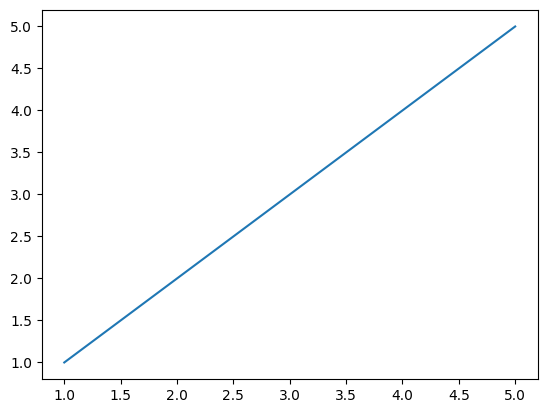

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array([1, 2,3,4,5])
y = np.array([1, 2,3,4,5])
plt.plot(x, y)
plt.show()

In [2]:
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx import mesh, fem, plot, io
from dolfinx.fem import Function, FunctionSpace

num_elements_X = 20
num_elements_Y = 10

domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (Length, W)), n=(num_elements_X, num_elements_Y),
                            cell_type=mesh.CellType.quadrilateral)
V = fem.VectorFunctionSpace(domain, ("Lagrange", 1))
#print(V.tabulate_dof_coordinates())
""" def funk(arrae):
    return np.array([1])

mesh.locate_entities(domain,2,funk(np.array([[1.],[0]]))) """

' def funk(arrae):\n    return np.array([1])\n\nmesh.locate_entities(domain,2,funk(np.array([[1.],[0]]))) '

In [3]:
lambda_ = fem.Constant(domain, E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu)))
mu = fem.Constant(domain, E / (2.0 * (1.0 + nu)))

In [13]:
E = 100
nu = 0.2
lambda_.value = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu.value = E / (2.0 * (1.0 + nu))

In [ ]:
""" Q = FunctionSpace(domain, ("DG", 0))

def evalLambda_(x):
    values = np.zeros(x.shape[1], dtype=ScalarType)
    top_coords = x[1]>0.1
    bottom_coords = x[1]<0.1
    values[top_coords] = np.full(sum(top_coords), 0)
    values[bottom_coords] = np.full(sum(bottom_coords), 0)
    #print(type(values), values.shape)
    return values
lambda_ = Function(Q)                       #lambda_ is a Function class' object
print(lambda_.x)
lambda_.interpolate(evalLambda_)            #interpolate is Function class' function


def evalMu_(x):
    values = np.zeros(x.shape[1], dtype=ScalarType)
    top_coords = x[1]>0.1
    bottom_coords = x[1]<0.1
    values[top_coords] = np.full(sum(top_coords), 0)
    values[bottom_coords] = np.full(sum(bottom_coords), 0)
    #print(values)
    return values

mu = Function(Q)
mu.interpolate(evalMu_) """

## Boundary conditions
As we would like to clamp the boundary at $x=0$, we do this by using a marker function, which locate the facets where $x$ is close to zero by machine prescision.

In [4]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0,0], dtype=ScalarType)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

As we want the traction $T$ over the remaining boundary to be $0$, we create a `dolfinx.Constant`

In [5]:
T = fem.Constant(domain, ScalarType((0, 0)))

We also want to specify the integration measure $\mathrm{d}s$, which should be the integral over the boundary of our domain. We do this by using `ufl`, and its built in integration measures

In [6]:
ds = ufl.Measure("ds", domain=domain)

## Variational formulation
We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [7]:

def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

In [8]:


u = ufl.TrialFunction(V)  #u is the object of the argument class
v = ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType((0, -rho*g)))
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

In [9]:
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx        ####################################

```{note}
Note that we used `nabla_grad` and optionally `nabla_div` for the variational formulation, as oposed to our previous usage of 
`div` and `grad`. This is because for scalar functions $\nabla u$ has a clear meaning
$\nabla u = \left(\frac{\partial u}{\partial x}, \frac{\partial u}{\partial y}, \frac{\partial u}{\partial z} \right)$.

However, if $u$ is vector valued, the meaning is less clear. Some sources define $\nabla u$ as a matrix with the elements $\frac{\partial u_j}{\partial x_i}$, while other  sources prefer 
$\frac{\partial u_i}{\partial x_j}$. In DOLFINx `grad(u)` is defined as the amtrix with element $\frac{\partial u_i}{\partial x_j}$. However, as it is common in continuum mechanics to use the other definition, `ufl` supplies us with `nabla_grad` for this purpose.
```
 
## Solve the linear variational problem
As in the previous demos, we assemble the matrix and right hand side vector and use PETSc to solve our variational problem

In [ ]:
#def func():
#    print(lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u))

In [10]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

In [14]:

uh = problem.solve()

## Visualization

As in the previous demos, we can either use Pyvista or Paraview for visualization. We start by using Pyvista. Instead of adding scalar values to the grid, we add vectors.

In [15]:
print(uh.x.array[400:])
#print(domain.x.shape)

[-2.64024971e-14 -3.10399664e+00 -9.15398711e-02 -3.33403516e+00
 -1.83199211e-01 -3.56350697e+00  4.46650446e-01 -2.18766349e+00
  3.60642782e-01 -2.41478945e+00  2.72263314e-01 -2.64379937e+00
  1.82311355e-01 -2.87377597e+00  9.14056479e-02 -3.10401393e+00
 -2.58904911e-14 -3.33402620e+00 -9.15854892e-02 -3.56345750e+00
  4.51733165e-01 -2.41518425e+00  3.63480364e-01 -2.64402888e+00
  2.73652342e-01 -2.87389619e+00  1.82862709e-01 -3.10406333e+00
  9.15398711e-02 -3.33403516e+00 -2.49709945e-14 -3.56343920e+00
  4.55094141e-01 -2.64428421e+00  3.65216004e-01 -2.87404134e+00
  2.74420720e-01 -3.10413703e+00  1.83116063e-01 -3.33406030e+00
  9.15854892e-02 -3.56345750e+00  4.57077178e-01 -2.87418816e+00
  3.66126545e-01 -3.10422044e+00  2.74759598e-01 -3.33409637e+00
  1.83199211e-01 -3.56350697e+00  4.58027261e-01 -3.10428982e+00
  3.66490714e-01 -3.33413390e+00  2.74862806e-01 -3.56357195e+00
  4.58312535e-01 -3.33415674e+00  3.66583633e-01 -3.56362888e+00
  4.58345194e-01 -3.56365

In [ ]:
print(uh._V.tabulate_dof_coordinates().shape)
print(uh._V.dofmap.list)

In [ ]:
from dolfinx import plot
import pyvista
pyvista.set_jupyter_backend("pythreejs")

topology, cell_types, geometry = plot.create_vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("fundamentals_mesh.png")

u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.reshape((u_geometry.shape[0], 2))
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [ ]:
#alt

import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   pyvista.start_xvfb()
   figure_as_array = p.screenshot("deflection.png")

We could also use Paraview for visualizing this.
As explained in previous sections, we save the solution with `XDMFFile`.
After opening the file `deformation.xdmf` in Paraview and pressing `Apply`, one can press the `Warp by vector button` ![Warp by vector](warp_by_vector.png) or go through the top menu (`Filters->Alphabetical->Warp by Vector`) and press `Apply`. We can also change the color of the deformed beam by changing the value in the color menu ![color](color.png) from `Solid Color` to `Deformation`.

In [ ]:
with io.XDMFFile(domain.comm, "2DCantilever_ohne_Abweichung_von_E.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    uh.name = "Deformation"
    xdmf.write_function(uh)

## Stress computation
As soon as the displacement is computed, we can compute various stress measures. We will compute the von Mises stress defined as $\sigma_m=\sqrt{\frac{3}{2}s:s}$ where $s$ is the deviatoric stress tensor $s(u)=\sigma(u)-\frac{1}{3}\mathrm{tr}(\sigma(u))I$.

In [ ]:
s = sigma(uh) -1./3*ufl.tr(sigma(uh))*ufl.Identity(uh.geometric_dimension())
von_Mises = ufl.sqrt(3./2*ufl.inner(s, s))

The `von_Mises` variable is now an expression that must be projected into an appropriate function space so that we can visualize it. As `uh` is a linear combination of first order piecewise continuous functions, the von Mises stresses will be a cell-wise constant function.

In [ ]:
V_von_mises = fem.FunctionSpace(domain, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points)
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

In the previous sections, we have only visualized first order Lagrangian functions. However, the Von Mises stresses are piecewise constant on each cell. Therefore, we modify our plotting routine slightly. The first thing we notice is that we  now set values for each cell, which has a one to one correspondence with the degrees of freedom in the function space.

In [ ]:
#warped.cell_data["VonMises"] = stresses.vector.array
#warped.set_active_scalars("VonMises")


""" u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.reshape((u_geometry.shape[0], 2))
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()


# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes() """

u_grid.cell_data["VonMises"] = stresses.vector.array #uh.x.array.reshape((u_geometry.shape[0], 2))
u_grid.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(u_grid)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   pyvista.start_xvfb()
   stress_figure = p.screenshot(f"stresses.png")

In [ ]:
a_true = 2.5
b_true = 1.7

n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 0.5

# generate the data
np.random.seed(seed)
x_test = np.linspace(0.0, 1.0, n_tests)
y_true = a_true * x_test + b_true
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
#a = np.array([4,3,2.5,2,1])
#b = np.array([3,2.5,1.7,1.3,1])
a = np.linspace(2.6,3.5,50)
b = np.linspace(1,2,50)
print(a,b)
cost_func = np.zeros((50,))
for i in range(50):
    result = a[i]*x_test + b[i]
    cost_func[i]=np.dot(result-y_test,result-y_test)

#print(cost_func)
plt.plot(a, cost_func,label="w.r.t. a")
plt.plot(b, cost_func, label="w.r.t. b")
plt.title("Cost_func Vs. parameters")
plt.xlabel("Parameters")
plt.ylabel("Cost function")
plt.legend()
plt.show()


In [ ]:
delta_y = y_test-y_true
#cost_value = np.dot(delta_y)
plt.plot(x_test, delta_y, label="ground-truth model")
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()